In [ ]:
#credits
https://towardsdatascience.com/predicate-vs-projection-pushdown-in-spark-3-ac24c4d11855
    https://www.bmc.com/blogs/python-spark-k-means-example/
- sampling: https://stackoverflow.com/questions/24806084/sampling-a-large-distributed-data-set-using-pyspark-spark
- filter pushing: https://engineering.dynatrace.com/blog/optimizing-spark-queries-with-filter-pushdown/
        -https://towardsdatascience.com/predicate-vs-projection-pushdown-in-spark-3-ac24c4d11855
            

In [1]:
!pip install pyspark



In [1]:
from pyspark.sql import SparkSession


In [2]:
import glob

In [3]:
pwd()

'D:\\Ethereum analysis - Copy'

In [4]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, TimestampType

In [5]:
from pyspark.sql import functions as F
#df.select(F.col("my_column"))

In [6]:
schema = StructType([ \
    StructField("sender",StringType(),True), \
    StructField("value",IntegerType(),True), \
    StructField("timestamp_in_unix_seconds",IntegerType(),True), \
    StructField("fee",IntegerType(),True), \
  ])

In [7]:
# spark.rdd.filter.csv.filterPushdown?
# spark config
from pyspark.conf import SparkConf


config = SparkConf().setAll([ \
    ('spark.executor.memory', '8g'), \
    ("spark.executor.instances", "4"), \

    ('spark.driver.memory','16g'), \
    ("spark.sql.parquet.filterPushdown", "true"), \
    ("spark.hadoop.parquet.filter.stats.enabled", "true"), \
    ("spark.sql.optimizer.nestedSchemaPruning.enabled", "true"), \
    ("spark.sql.optimizer.dynamicPartitionPruning.enabled", "true"), \
    ("spark.sql.autoBroadcastJoinThreshold", "-1"), \
    ("spark.sql.parquet.binaryAsString", "true") ]) \
#    ("spark.executor.memoryOverhead", "16384") \





In [8]:
print(config.setMaster("local").setAppName("Clustering using K-Means"))

print(config.get("spark.master"))

print(config.get("spark.app.name"))


local
Clustering using K-Means


In [9]:
import time

from datetime import datetime
spark = SparkSession.builder.appName("Clustering using K-Means") \
    .config(conf=config) \
    .getOrCreate() \
#    .option("failOnDataLoss", False)
#spark

In [10]:
spark

In [11]:
spark.sparkContext.getConf().getAll()

[('spark.master', 'local'),
 ('spark.driver.host', '10.0.7.40'),
 ('spark.executor.instances', '4'),
 ('spark.sql.parquet.binaryAsString', 'true'),
 ('spark.sql.parquet.filterPushdown', 'true'),
 ('spark.driver.port', '56296'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.optimizer.dynamicPartitionPruning.enabled', 'true'),
 ('spark.driver.memory', '16g'),
 ('spark.sql.optimizer.nestedSchemaPruning.enabled', 'true'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.startTime', '1637865213214'),
 ('spark.executor.memory', '8g'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.hadoop.parquet.filter.stats.enabled', 'true'),
 ('spark.sql.autoBroadcastJoinThreshold', '-1'),
 ('spark.sql.warehouse.dir',
  'file:/D:/Ethereum%20analysis%20-%20Copy/spark-warehouse'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'Clustering using K-Means'),
 ('spark.app.id', 'local-1637865219365')]

In [12]:
# help received for reading several files: https://stackoverflow.com/questions/49898742/pandas-reading-csv-files-with-partial-wildcard

import glob
import os
ETHEREUM_PATHS = sorted(glob.glob(os.path.join("D:\\Downloads\\ethereum\\", "ethereum*.csv")))
ETHEREUM_PATHS

['D:\\Downloads\\ethereum\\ethereum000000000000.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000001.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000002.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000003.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000004.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000005.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000006.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000007.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000008.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000009.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000010.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000011.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000012.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000013.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000014.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000015.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000016.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000017.csv',
 'D:\\Downloads\\ethereum\\e

In [13]:
# deal with date value (1): https://stackoverflow.com/questions/19480028/attributeerror-datetime-module-has-no-attribute-strptime
# deal with date value (2) :https://stackoverflow.com/questions/19801727/convert-datetime-to-unix-timestamp-and-convert-it-back-in-python
# hier wird dataframe gelesen. versuche es mit rdd .rdd()
data_customer=spark.read.csv(ETHEREUM_PATHS, header=True, schema=schema) \
    .select("sender","value","fee") \
    .filter( \
        ((F.col('timestamp_in_unix_seconds') >= int(time.mktime(datetime.strptime('2015-07-30', '%Y-%m-%d').timetuple()))) & (F.col('timestamp_in_unix_seconds') <= int(time.mktime(datetime.strptime('2017-12-18', '%Y-%m-%d').timetuple())))) |\
        ((F.col('timestamp_in_unix_seconds') >= int(time.mktime(datetime.strptime('2018-12-16', '%Y-%m-%d').timetuple()))) & (F.col('timestamp_in_unix_seconds') <= int(time.mktime(datetime.strptime('2021-04-13', '%Y-%m-%d').timetuple())))) \
            
           ) \
    .sample(False,0.01,1234) \
    .na.drop() \
    .persist()
data_customer.printSchema()

root
 |-- sender: string (nullable = true)
 |-- value: integer (nullable = true)
 |-- fee: integer (nullable = true)



In [14]:
data_customer.explain()

== Physical Plan ==
InMemoryTableScan [sender#0, value#1, fee#3]
   +- InMemoryRelation [sender#0, value#1, fee#3], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- *(1) Filter AtLeastNNulls(n, sender#0,value#1,fee#3)
            +- *(1) Sample 0.0, 0.01, false, 1234
               +- *(1) Project [sender#0, value#1, fee#3]
                  +- *(1) Filter (((timestamp_in_unix_seconds#2 >= 1438207200) AND (timestamp_in_unix_seconds#2 <= 1513551600)) OR ((timestamp_in_unix_seconds#2 >= 1544914800) AND (timestamp_in_unix_seconds#2 <= 1618264800)))
                     +- FileScan csv [sender#0,value#1,timestamp_in_unix_seconds#2,fee#3] Batched: false, DataFilters: [(((timestamp_in_unix_seconds#2 >= 1438207200) AND (timestamp_in_unix_seconds#2 <= 1513551600)) O..., Format: CSV, Location: InMemoryFileIndex[file:/D:/Downloads/ethereum/ethereum000000000000.csv, file:/D:/Downloads/ethere..., PartitionFilters: [], PushedFilters: [Or(And(GreaterThanOrEqual(timestamp_in_unix_seco

In [15]:
data_customer.show(2)

+--------------------+---------+------+
|              sender|    value|   fee|
+--------------------+---------+------+
|0xf42b80c4e61e881...|100000000| 50000|
|0x77d29800ab48256...|        1|300000|
+--------------------+---------+------+
only showing top 2 rows



In [16]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)
sqlContext.registerDataFrameAsTable(data_customer, "table1")
df2 = sqlContext.sql(" \
                     with counted_sender as (SELECT sender, count(*) as c \
                     from table1 group by sender) \
                     select table1.sender, avg(value) as avg_value, avg(fee) as avg_fee, c \
                     from table1 join counted_sender on table1.sender=counted_sender.sender \
                     group by table1.sender, c order by c desc"
                    )

In [17]:
# sender are filtered out, since they are hash values --> do not contain any structure
inputCols=['avg_value', 'avg_fee', 'c']


In [18]:
# transformation task. genau wie filter, join, etc. --> bis hier wird das aber nur vorbereitet
from pyspark.ml.feature import VectorAssembler
df2.columns
assemble=VectorAssembler(inputCols=inputCols, outputCol='features')
assembled_data=assemble.transform(df2)
assembled_data.show(2)

+--------------------+---------+------------------+---+--------------------+
|              sender|avg_value|           avg_fee|  c|            features|
+--------------------+---------+------------------+---+--------------------+
|0x1f93b5e75a04b22...|      1.0|266877.73722627736|548|[1.0,266877.73722...|
|0xc400b9d93a23b0b...|      1.0|  319672.131147541|488|[1.0,319672.13114...|
+--------------------+---------+------------------+---+--------------------+
only showing top 2 rows



In [19]:
# an dieser stelle findet erstmals eine aktion statt. die vorbereiteten transformationen werden durchgeführt.
#standarizer
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized', withMean=True, withStd=True)
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+--------------------+---------+------------------+---+--------------------+--------------------+
|              sender|avg_value|           avg_fee|  c|            features|        standardized|
+--------------------+---------+------------------+---+--------------------+--------------------+
|0x1f93b5e75a04b22...|      1.0|266877.73722627736|548|[1.0,266877.73722...|[-0.2403291173618...|
|0xc400b9d93a23b0b...|      1.0|  319672.131147541|488|[1.0,319672.13114...|[-0.2403291173618...|
+--------------------+---------+------------------+---+--------------------+--------------------+
only showing top 2 rows



In [20]:
#from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import PCA
pca = PCA(k=3, inputCol="standardized")
pca.setOutputCol("pca_features")
model = pca.fit(data_scale_output)
data_scale_output = model.transform(data_scale_output)

In [21]:
data_scale_output.show(2)

+--------------------+---------+------------------+---+--------------------+--------------------+--------------------+
|              sender|avg_value|           avg_fee|  c|            features|        standardized|        pca_features|
+--------------------+---------+------------------+---+--------------------+--------------------+--------------------+
|0x1f93b5e75a04b22...|      1.0|266877.73722627736|548|[1.0,266877.73722...|[-0.2403291173618...|[17.7088153650114...|
|0xc400b9d93a23b0b...|      1.0|  319672.131147541|488|[1.0,319672.13114...|[-0.2403291173618...|[15.8141594037943...|
+--------------------+---------+------------------+---+--------------------+--------------------+--------------------+
only showing top 2 rows



In [22]:
# variance explained
model.explainedVariance

DenseVector([0.3413, 0.3307, 0.3279])

In [23]:
model.pc

DenseMatrix(3, 3, [-0.4972, 0.6188, 0.6082, -0.8656, -0.3061, -0.3962, -0.059, -0.7234, 0.6879], 0)

In [24]:
# help received from: https://stackoverflow.com/questions/59883306/how-to-drop-a-column-from-a-spark-dataframe-by-index-where-column-names-can-be-d
# pca plot variance explained https://datascience-enthusiast.com/Python/PCA_Spark_Python_R
# PCs: each PC represents a "cluster" of sender and its behaviour
import numpy as np
import pandas as pd
pcs = np.round(model.pc.toArray(),4)
df_pc = pd.DataFrame(pcs, columns = ['PC'+str(i) for i in range(1, 4)], index = inputCols)
df_pc
# pc is actually a dimension reduction technique, to bring high dimensional data into smaller ones. 
# It therefore tries to bring variable data into a new   coordinate system where variance in the data is observed
# but everything can be represented with fewer amount of dimensions. This technique is here used not ffor visualization
# but for explaining the patterns in the data by means of observing the representation of the various columns in the new PCs.

# interpretation: PC2 shows that people with most transactions pay less fee.
# PC3 shwos peope that pay huge transaction value for relatively high  fee
# PC1 shows that there are people that pay huge fee for less transaction value
# ...through the interpretation of therese 3 PCs that are all needed to explain at leas 80% of the variance, we can interpret the clusters
# the signs in the PCs are arbitrary, but the direction of the value play a role

,PC1,PC2,PC3
avg_value,-0.4972,-0.8656,-0.0590
avg_fee,0.6188,-0.3061,-0.7234
c,0.6082,-0.3962,0.6879


In [25]:
#data_customer = data_scale_output.toPandas()

In [26]:
%%time
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i, seed=1) # set seed
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.9925491169913631
Silhouette Score: 0.9617541154621412
Silhouette Score: 0.9462478333256237
Silhouette Score: 0.9343760508867063
Silhouette Score: 0.8224431782706874
Silhouette Score: 0.8537902846746522
Silhouette Score: 0.6154925640422266
Silhouette Score: 0.6960978769879638
Wall time: 1h 16min 48s


Text(0, 0.5, 'silhouette score')

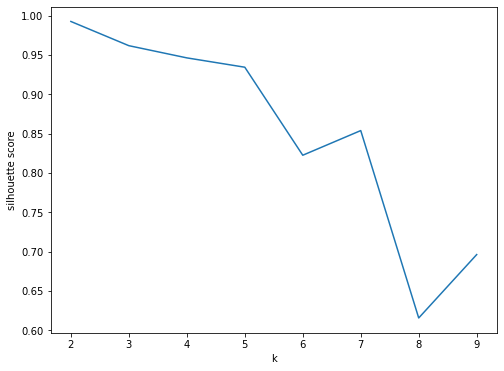

In [27]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel("k")
ax.set_ylabel("silhouette score")

In [28]:



from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

# Trains a k-means model.
kmeans = KMeans(featuresCol='standardized').setK(4).setSeed(1)
model = kmeans.fit(data_scale_output)

# Make predictions
predictions = model.transform(data_scale_output)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()


silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette)) 
# evaluation mit silhouette; evaluation mit SSE ist depriciated



Silhouette with squared euclidean distance = -0.8516965895575791


In [29]:
# Shows the result.
print("Cluster Centers: ")
ctr=[]
centers = model.clusterCenters()
for center in centers:
    ctr.append(center)
    print(center)

Cluster Centers: 
[-0.19303985 -0.05058557 -0.03589901]
[-2.40329117e-01 -1.36396308e-02  2.35725044e+01]
[0.17896248 9.00052753 0.12782141]
[ 4.60581166 -0.12135069 -0.03218871]


In [30]:
# output of transform "output" or "predictions"
pandasDF=predictions.toPandas()

In [31]:
pandasDF
#wieso wurden orignaldaten in model gegeben? wieso nicht einfach nur standardized? 
# -- tatsächlich wurden nur standardized /features bearbeitet

,sender,avg_value,avg_fee,c,features,standardized,pca_features,prediction
0,0x1f93b5e75a04b225816935c3d65f552cac88a61b,1.000000e+00,266877.737226,548,"[1.0, 266877.73722627736, 548.0]","[-0.24032911736180426, -0.054888688724150606, ...","[17.708815365011443, -11.256750185769803, 19.9...",1
1,0xc400b9d93a23b0be5d41ab337ad605988aef8463,1.000000e+00,319672.131148,488,"[1.0, 319672.131147541, 488.0]","[-0.24032911736180426, 0.018747632110449466, 2...","[15.814159403794323, -10.015232381463175, 17.7...",1
2,0x90384d665f5687be20fa3efc029939d249f0570c,1.000000e+00,302805.280528,303,"[1.0, 302805.2805280528, 303.0]","[-0.24032911736180426, -0.004777835868938899, ...","[9.817241825891172, -6.1105201054160885, 10.98...",1
3,0xd53a5b3b4abd15fbffff98b632422e3c9c78fba9,3.697561e+01,359756.097561,123,"[36.97560975609756, 359756.0975609756, 123.0]","[-0.24032895865026604, 0.07465576158997349, 6....","[4.045724112589097, -2.3426616005619554, 4.348...",0
4,0x5a600bf604dad0135e20afbac74a05eeee265055,9.686957e+06,50706.086957,115,"[9686956.52173913, 50706.086956521736, 115.0]","[-0.19759373019597082, -0.35639958433834323, 5...","[3.4990284602875494, -2.0791687130267884, 4.36...",0
...,...,...,...,...,...,...,...,...
2031,0x81fbaecfdeb11cd20d91e9549d9752d9185b4970,1.843399e+08,21000.000000,1,"[184339917.0, 21000.0, 1.0]","[0.5729127379040779, -0.3978329030564873, -0.1...","[-0.5961240838662516, -0.33175225403735614, 0....",0
2032,0x86b4c7bc6a2fada0d11165aab4aa0b30ff3d2164,1.000000e+08,21000.000000,1,"[100000000.0, 21000.0, 1.0]","[0.20083515393658544, -0.3978329030564873, -0....","[-0.41113212010658284, -0.009669646123712829, ...",0
2033,0xae0bf57678cf8151ff95889078e944a7696e18d5,1.000000e+00,831333.000000,1,"[1.0, 831333.0, 1.0]","[-0.24032911736180426, 0.7323996148099814, -0....","[0.5076350018083022, 0.026255534554212152, -0....",0
2034,0xaee9d6d117b4fdc73d13796ad289fcf9b5fc6cfb,1.000000e+00,40000.000000,1,"[1.0, 40000.0, 1.0]","[-0.24032911736180426, -0.37133217083965436, -...","[-0.17539163458457158, 0.36410487016374826, 0....",0


In [32]:
import pandas as pd
centers = pd.DataFrame(ctr,columns=inputCols)
centers # könnte man einzeichnen, wenn man plot mit skalierten daten (nicht pca -daten) macht

,avg_value,avg_fee,c
0,-0.193040,-0.050586,-0.035899
1,-0.240329,-0.013640,23.572504
2,0.178962,9.000528,0.127821
3,4.605812,-0.121351,-0.032189


In [33]:
# plot pca
#pca_pandas = pandasDF.toPandas()
x = []
y = []
z = []
for i, j, k in pandasDF["pca_features"].values:
    x.append(i)
    y.append(j)
    z.append(k)

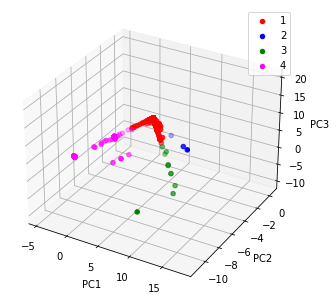

In [34]:
# help: u.a. https://stackoverflow.com/questions/37711538/matplotlib-3d-axes-ticks-labels-and-latex
# todo change size:https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib

import matplotlib.pyplot as plt

import numpy as np
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
scatter_x = np.array(x) # scaled bitcoin transaction avg_value
scatter_y = np.array(y) # scaled bitcoin transaction avg_fee
scatter_z = np.array(z) # scaled bitcoin transaction count
group = np.array(pandasDF['prediction'])

cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'magenta'}
#fig, ax = plt.subplots()
fig = pyplot.figure()
ax = Axes3D(fig)
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], scatter_z[ix], c = cdict[g], label = g+1)
ax.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

In [35]:
# bring scaled values(value, fee) into list
# 3 gegeben durch anzahl columns (nicht anzahl clusters nach kmeans)
x = []
y = []
z = []
for i, j, k in pandasDF["standardized"].values:
    x.append(i)
    y.append(j)
    z.append(k)

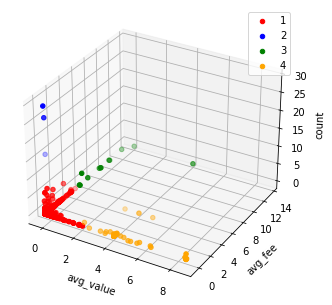

In [36]:
# help: u.a. https://stackoverflow.com/questions/37711538/matplotlib-3d-axes-ticks-labels-and-latex

import matplotlib.pyplot as plt

# plot mit scaled daten: value vs. fee
#todo: outlier entfernen
#todo: mean centers rein tun
import numpy as np
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
scatter_x = np.array(x) # scaled bitcoin transaction avg_value
scatter_y = np.array(y) # scaled bitcoin transaction avg_fee
scatter_z = np.array(z) # scaled bitcoin transaction count
group = np.array(pandasDF['prediction'])

cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange'}
#fig, ax = plt.subplots()
fig = pyplot.figure()
ax = Axes3D(fig)
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], scatter_z[ix], c = cdict[g], label = g+1)
ax.legend()
plt.xlabel("avg_value")
plt.ylabel("avg_fee")
ax.set_zlabel("count")
plt.show()

#plt.scatter(y=pandasDF["fee"],x=pandasDF["value"], c=pandasDF["prediction"], cmap='brg')
#plt.legend()

#plt.scatter(y=y,x=x, c=pandasDF["prediction"].values, cmap='brg')
#plt.legend()



# interpretation:
- 2010-2011 waren fees sehr günstig. zum teil waren transaktionen auch gratis. daher ist fee relativ weit unten
- fee plot ist auch etwas gezerrt wegen outlier oben
- die drei cluster
-- transaktionen mit wenig fee und wenig betrag
-- transaktionen mit wenig fee und viel betrag
-- transaktionen mit etwas höherem fees haben etwas höheren betrag

In [37]:
class1 = pandasDF.loc[pandasDF['prediction'] == 0]
class2 = pandasDF.loc[pandasDF['prediction'] == 1]
class3 = pandasDF.loc[pandasDF['prediction'] == 2]
class4 = pandasDF.loc[pandasDF['prediction'] == 3]

{'whiskers': [<matplotlib.lines.Line2D at 0x280885ee340>,
 'caps': [<matplotlib.lines.Line2D at 0x280885f1c10>,
 'boxes': [<matplotlib.lines.Line2D at 0x280885eae80>,
 'medians': [<matplotlib.lines.Line2D at 0x280885f1e50>,
 'fliers': [<matplotlib.lines.Line2D at 0x280885f6340>,
 'means': []}

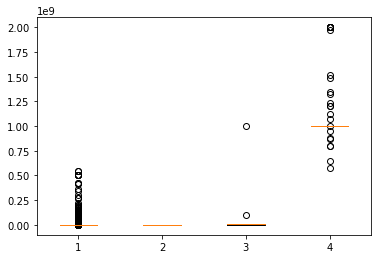

In [38]:
plt.boxplot([class1["avg_value"], class2["avg_value"], class3["avg_value"], class4["avg_value"]])

{'whiskers': [<matplotlib.lines.Line2D at 0x2808866deb0>,
 'caps': [<matplotlib.lines.Line2D at 0x28088671b20>,
 'boxes': [<matplotlib.lines.Line2D at 0x2808866d760>,
 'medians': [<matplotlib.lines.Line2D at 0x28088676760>,
 'fliers': [<matplotlib.lines.Line2D at 0x28088676eb0>,
 'means': []}

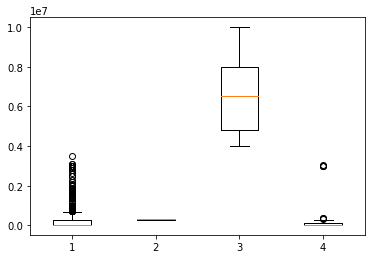

In [39]:
plt.boxplot([class1["avg_fee"], class2["avg_fee"], class3["avg_fee"], class4["avg_fee"]])

{'whiskers': [<matplotlib.lines.Line2D at 0x280886eaa00>,
 'caps': [<matplotlib.lines.Line2D at 0x280886ee670>,
 'boxes': [<matplotlib.lines.Line2D at 0x280886ea2b0>,
 'medians': [<matplotlib.lines.Line2D at 0x280886f22b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x280886f2a00>,
 'means': []}

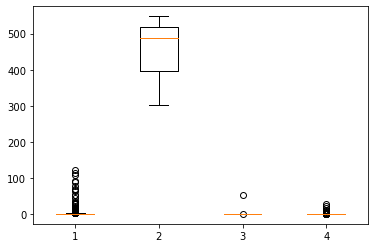

In [40]:
plt.boxplot([class1["c"], class2["c"], class3["c"], class4["c"]])